In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.nn import leaky_relu
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.keras.utils import plot_model, Progbar
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
# import tensorflow_ranking as tfr
from sklearn.model_selection import train_test_split
import os, time, gc, json, math, random, re
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from ast import literal_eval
import multiprocessing
import itertools
from sklearn.metrics.pairwise import cosine_similarity, pairwise_kernels
from itertools import combinations
import matplotlib.pyplot as plt
from scipy import ndimage
import lightgbm as lgb
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


fea_prod = ['product_sku_hash_id_lag5', 'product_sku_hash_id_lag4', 'product_sku_hash_id_lag3', 
            'product_sku_hash_id_lag2', 'product_sku_hash_id_lag1', 'product_sku_hash_id']
fea_url = ['hashed_url_id_lag5', 'hashed_url_id_lag4', 'hashed_url_id_lag3', 
           'hashed_url_id_lag2', 'hashed_url_id_lag1', 'hashed_url_id']
features = fea_prod + fea_url

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [54]:
def str_to_list(x):
        if not isinstance(x, str) and np.isnan(x):
            return []
        else:
            return literal_eval(x)
        
def add_fea_using_matrix(df, matrix, suffix='_sim', col='product_sku_hash_id', keycol='target_sku'):
    for c in [c for c in df.columns if (c.startswith(col) and bool(re.search('lag[0-9]*$', c))) or (c == col)]:
        if c + suffix not in df.columns:
            df[c + suffix] = matrix[df[c].astype(int), df[keycol].astype(int)]
            print('created ' + c + suffix)

@tf.function
def get_topk_pred(model, x, topk=tf.constant(3)):
    # this is for tf dataset version
    y_pred = model(x, training=False)
    col_to_zero = [naid, minorid]
    tnsr_shape=tf.shape(y_pred['logits'])
    mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1]) for col_num in col_to_zero]
    mask = tf.reduce_sum(mask, axis=0) * -9999
    y_pred['logits'] = tf.add(y_pred['logits'], mask)
    
    # topk items' id for each session, 2d array
    top = tf.math.top_k(y_pred['logits'], k=topk)
    return top.indices, keras.activations.sigmoid(top.values)

def explode(x):
    if x.name in ['neg_sku_list','neg_sku_score']:
        return pd.Series.explode(x)
    else:
        return x


In [48]:
# can simply reuse df_browse_v3_update
df_browse = pd.read_parquet('df_browse_v3_update')
# df_browse['sample_weights'] = pd.to_datetime(df_browse.server_day).dt.month

skucate = df_browse.product_sku_hash.cat
num_sku = df_browse.product_sku_hash_id_lag1.max() + 1
num_url = df_browse.hashed_url_id_lag1.max() + 1

# get num_x from x_lag1 because function create_shift_features
# may created a new_id in lag columns
naid = df_browse.product_sku_hash.cat.categories.tolist().index('_')
minorid = df_browse.product_sku_hash.cat.categories.tolist().index('minority')

# note this df_test is used for cal testing MRR later, 
# it is different from the df_test used for training
if not os.path.exists('df_test_update8'):
    df_test = df_browse[df_browse.train==0].copy()
    df_test = df_test.loc[df_test.next_interacted_sku!=naid]
    df_test.to_parquet('df_test_update8')
    del df_test
    gc.collect()

if not os.path.exists('df_train_update8'):
    df_train = df_browse[df_browse.train==1]
    df_train = df_train[(df_train.next_sku!=naid)].reset_index(drop=True)
    # include testing data into training
    df_test = df_browse[df_browse.train==0]
    df_test = df_test[(df_test.next_sku!=naid)].reset_index(drop=True)
    
    def strafiedkfold(df, idcol, k=5):
        """
        sklearn kfold will do unnessary sorting
        so build my own function
        """
        df_kidx = df_train.session_id_hash.unique()
        np.random.seed(123)
        np.random.shuffle(df_kidx)
        df_kidx = pd.DataFrame({idcol: df_kidx})
        df_kidx['kfoldidx'] = df_kidx.index % k
        df = df.merge(df_kidx, on=idcol, copy=False)
        print(df['kfoldidx'].value_counts())
        return df

    df_train.drop(columns='kfoldidx', inplace=True)
    df_test['kfoldidx'] = 1
    df_train = strafiedkfold(df_train, 'session_id_hash', k=5)
    df_train = pd.concat([df_train, df_test])
    # x_train_weights = df_train.loc[df_train.kfoldidx!=0].sample_weights.reset_index(drop=True)
    df_train.to_parquet('df_train_update8')

    del df_test, df_train
    gc.collect()

if not os.path.exists('df_submission'):
    df_submission = df_browse[df_browse.train==0]
    df_submission = df_submission.groupby('session_id_hash').tail(1).reset_index(drop=True)
    df_submission.to_parquet('df_submission')
    gc.collect()
    
del df_browse
gc.collect()

0

# Resume Stage 1 model

In [4]:
# model architecture
class MLP(Model):
    def __init__(self, num_sku, num_url, embed_dim=312):
        super().__init__()
        
        self.normal_init = keras.initializers.RandomNormal(mean=0., stddev=0.01)
        
        self.sku_embed = layers.Embedding(num_sku, embed_dim, self.normal_init)
        self.url_embed = layers.Embedding(num_url, embed_dim, self.normal_init)
        
        self.dense1 = layers.Dense(1024)
        self.norm1 = layers.BatchNormalization()
        self.activate1 = layers.ReLU()
        self.dropout1 = layers.Dropout(0.2)
        
        self.dense2 = layers.Dense(1024)
        self.norm2 = layers.BatchNormalization()
        self.activate2 = layers.ReLU()
        self.dropout2 = layers.Dropout(0.2)
        
        self.dense3 = layers.Dense(embed_dim)
        self.norm3 = layers.BatchNormalization()
        self.activate3 = layers.ReLU(name='sess_embed')
        self.dropout3 = layers.Dropout(0.2)
        
        self.output_bias = tf.random.normal((num_sku,), 0., 0.01)
    
    def call(self, inputs):
        lag_sku, lag_url = inputs['sku'], inputs['url']
        
        sku_embed = layers.Flatten()(self.sku_embed(lag_sku))
        url_embed = layers.Flatten()(self.url_embed(lag_url))
        
        x = layers.concatenate([sku_embed, url_embed])
        x = self.activate1(self.norm1(self.dense1(x)))
        x = self.dropout1(x)

        x = self.activate2(self.norm2(self.dense2(x)))
        x = self.dropout2(x)

        sess_embed = self.activate3(self.norm3(self.dense3(x)))
        x = self.dropout3(sess_embed)
        
        x = tf.matmul(x, tf.transpose(self.sku_embed.weights[0]))
        logits = tf.nn.bias_add(x, self.output_bias, name='logits')

        return {'logits': logits, 'embed': sess_embed}
    
    def build_graph(self):
        x = {'sku': Input(shape=(6)), 'url': Input(shape=(6))}
        return Model(inputs=x, outputs=self.call(x))
    
    def predict_subset(self, x, u, l):
        _x = []
        for i in range(len(x)):
            _x.append(x[i][u:l])
        return self.predict(_x)
    
keras.utils.plot_model(MLP(num_sku, num_url).build_graph(), show_shapes=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [5]:
x_train_one = {'sku': np.random.randint(num_sku, size=(10, 6)), 'url': np.random.randint(num_url, size=(10, 6))}
y_train_one = np.random.randint(num_sku,size=(10,))
tf_train_one = tf.data.Dataset.from_tensor_slices((x_train_one, y_train_one)).batch(2)
del x_train_one, y_train_one
gc.collect()

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model_mlp = MLP(num_sku, num_url)
    LossFunc = {'logits':keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'embed':None}
    metrics = {'logits': [keras.metrics.SparseCategoricalAccuracy(name='top1_acc'), 
                      keras.metrics.SparseTopKCategoricalAccuracy(k=20, name='top20_acc')]}
    model_mlp.compile(optimizer='adam', loss=LossFunc, metrics=metrics)
history = model_mlp.fit(tf_train_one, epochs=1)
model_mlp.load_weights('model_update8.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
5/5 [==============================] - 6s 408ms/step - loss: 10.6874 - logits_loss: 10.6874 - logits_top1_acc: 0.0000e+00 - logits_top20_acc: 0.0000e+00


# Ranking

In [94]:
df_train = pd.read_parquet('df_train_update8')

In [95]:
# todo: only testing data and validation to test the model for now
df_train = df_train.loc[(df_train.train==0) | (df_train.kfoldidx==0)]
df_train.shape

(2040354, 37)

In [96]:
df_train['idx'] = np.arange(df_train.shape[0])
df_train['n'] = df_train.groupby('session_id_hash').cumcount()

# each original record is treated as a query
df_train['query_id'] = df_train['session_id_hash'] + '_' + df_train['n'].astype(str)

In [97]:
#
# POSITIVE samples
#
s = time.time()

# todo: get next 1 unique sku as pos samples for now
tmp = df_train.groupby('session_id_hash')['next_sku'].agg(list).reset_index()
tmp.columns = ['session_id_hash', 'pos_sku_list']
df_train = df_train.merge(tmp, on='session_id_hash', how='left')

def get_pos_sku_list(x):
    items = x['pos_sku_list'][x['n']:(x['n'] + 1)]
    # if items = [46639.0, 46639.0, 16598.0, 25232.0, 46639.0]
    # return [46639, 16598, 25232] <- length depends on hard coded number above
    return list(dict.fromkeys(items))

df_train['pos_sku_list'] = df_train[['pos_sku_list','n']].parallel_apply(get_pos_sku_list, axis = 1)

print(time.time()-s)

del tmp
gc.collect()

23.449233531951904


0

In [103]:
#
# NEGATIVE Samples
#

# get top k pred for each record
batch_size = 2000
tf_all = tf.data.Dataset.from_tensor_slices({'sku':df_train[fea_prod].values, 'url':df_train[fea_url].values}).batch(batch_size)
dist_all = strategy.experimental_distribute_dataset(tf_all)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
#todo: rerank only top 20 for now
topk = tf.constant(20)

for x in dist_all:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 1000 == 0:
        print(i, time.time()-s)

s= time.time()

neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_train['neg_sku_list'] = neg_sku_list
df_train['neg_sku_score'] = score_list

print(time.time()-s)

del tf_all, dist_all
gc.collect()

tf.Tensor(1000, shape=(), dtype=int32) 193.29622292518616
12.037820100784302


106

In [104]:
# remove queries if no pos sample in neg_sku_list
s= time.time()

def get_neg_sku_list(x):
    items = x['pos_sku_list']
    for i in items: 
        if i in x['neg_sku_list']:
            return 1
    return 0

# further split it into "chunk"
# because if df_train gets too large, pickle in parallel_apply takes too long
chunk = 1
interval = int(np.ceil(df_train.shape[0] / chunk))
pos_in_neg_sku_list = []
for j in range(chunk):
    pos_in_neg_sku_list = pos_in_neg_sku_list + df_train.loc[(interval*j):(interval*(j+1)), ['neg_sku_list','pos_sku_list']].parallel_apply(get_neg_sku_list, axis = 1).tolist()
    print(time.time()-s)

df_train['pos_in_neg'] = pos_in_neg_sku_list
df_train = df_train.loc[df_train.pos_in_neg==1]
df_train.drop(columns='pos_in_neg', inplace=True)

del neg_sku_list, pos_in_neg_sku_list
gc.collect()

109.06918048858643


0

In [107]:
# explode score and neg_sku_list
df_train = df_train.apply(explode).reset_index(drop=True)

In [109]:
df_train['target_sku'] = df_train['neg_sku_list']

In [110]:
# add label for each sku
# i indexed sku in pos_sku_list has score of len(pos_sku_list) - i
def get_sku_label(x):
    if x['target_sku'] not in x['pos_sku_list']:
        return 0 
    else:
        pos_sku_list = list(x['pos_sku_list'])
        return len(pos_sku_list) - pos_sku_list.index(x['target_sku'])

df_train['label'] = df_train[['pos_sku_list','target_sku']].parallel_apply(lambda x: get_sku_label(x), axis = 1) 

In [111]:
df_train.drop(columns=['pos_sku_list','neg_sku_list'], inplace=True)

In [112]:
df_train.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,train,server_day,product_sku_hash_id,hashed_url_id,...,next_sku,next_interacted_sku,rand_id,kfoldidx,idx,n,query_id,neg_sku_score,target_sku,label
0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,pageview,_,_,2019-03-29 19:16:25.830,4bea6285a7df7a717620b5705bd818dfc42a5a0de04f30...,1,2019-03-29,25402,70784,...,7067,7067.0,16,0,0,0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,0.546782,32766,0
1,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,pageview,_,_,2019-03-29 19:16:25.830,4bea6285a7df7a717620b5705bd818dfc42a5a0de04f30...,1,2019-03-29,25402,70784,...,7067,7067.0,16,0,0,0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,0.513361,2983,0
2,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,pageview,_,_,2019-03-29 19:16:25.830,4bea6285a7df7a717620b5705bd818dfc42a5a0de04f30...,1,2019-03-29,25402,70784,...,7067,7067.0,16,0,0,0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,0.44678,5093,0
3,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,pageview,_,_,2019-03-29 19:16:25.830,4bea6285a7df7a717620b5705bd818dfc42a5a0de04f30...,1,2019-03-29,25402,70784,...,7067,7067.0,16,0,0,0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,0.42498,7067,1
4,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,pageview,_,_,2019-03-29 19:16:25.830,4bea6285a7df7a717620b5705bd818dfc42a5a0de04f30...,1,2019-03-29,25402,70784,...,7067,7067.0,16,0,0,0,0000481159d514ba59c3ccfa77c5767c9d14ac14e99232...,0.405417,16570,0


In [113]:
#
# Prepare item by item matrix
# 1. sku similarity
# 2. description similarity
# 3. same category
# 4. same price
# 5. image similarity
#

if not os.path.exists('sku_sim_update8.npy'):
    print('creating sku_sim')
    sku_embed = model_mlp.sku_embed.get_weights()[0]
    sku_sim = pairwise_kernels(sku_embed, sku_embed, metric='cosine', n_jobs=-1)
    np.save('sku_sim_update8', sku_sim)
    del sku_embed, sku_sim
    gc.collect()
    
if not os.path.exists('desc_sim_update8.npy') or not os.path.exists('img_sim_update8.npy') or not os.path.exists('cate_same_update8.npy') or not os.path.exists('price_same_update8.npy'):
    df_sku = pd.read_csv("./data/sku_to_content.csv")
    df_sku['description_vector_l'] = df_sku.description_vector.apply(str_to_list)
    df_sku['image_vector_l'] = df_sku.image_vector.apply(str_to_list)
    
    # cate and price of each sku
    df_skuid_cate_price = pd.DataFrame(skucate.categories)
    df_skuid_cate_price.columns = ['product_sku_hash']
    df_skuid_cate_price = df_skuid_cate_price.merge(df_sku[['product_sku_hash', 'category_hash', 'price_bucket']], how='left', on='product_sku_hash')
    assert df_skuid_cate_price.shape[0] == num_sku, 'more than 1 cate or price for some skus'

    # get desc/img embed
    def get_descimg_embed(idx, col='description_vector_l'):
        try:
            sku = skucate.categories[idx]
            embed = df_sku[col][df_sku.product_sku_hash==sku].values[0]
            if len(embed) == 0:
                return np.zeros(50)
            else:
                return embed
        except (IndexError, ValueError):
            return np.zeros(50)
            
    if not os.path.exists('desc_sim_update8.npy'):
        print('creating desc_sim')
        desc_embed = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(get_descimg_embed)(i) for i in trange(num_sku))
        desc_embed = np.array(desc_embed)
        desc_sim = pairwise_kernels(desc_embed, desc_embed, metric='cosine', n_jobs=-1)
        desc_sim = desc_sim.astype(np.float32)
        np.save('desc_sim_update8', desc_sim)
        del desc_embed, desc_sim
        gc.collect()
    
    if not os.path.exists('img_sim_update8.npy'):
        print('creating img_sim')
        img_embed = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(get_descimg_embed)(i, 'image_vector_l') for i in trange(num_sku))
        img_embed = np.array(img_embed)
        img_sim = pairwise_kernels(img_embed, img_embed, metric='cosine', n_jobs=-1)
        img_sim = img_sim.astype(np.float32)
        np.save('img_sim_update8', img_sim)
        del img_embed, img_sim
        gc.collect()
     
    if not os.path.exists('cate_same_update8.npy'):
        print('creating cate_same')
        cate_same = np.array(df_skuid_cate_price.category_hash)
        cate_same = (cate_same == np.expand_dims(cate_same, 1)).astype(np.int8)
        np.save('cate_same_update8', cate_same)
        del cate_same
        gc.collect()
    
    if not os.path.exists('price_same_update8.npy'):
        print('creating price_same')
        price_same = np.array(df_skuid_cate_price.category_hash)
        price_same = (price_same == np.expand_dims(price_same, 1)).astype(np.int8)
        np.save('price_same_update8', price_same)
        del price_same
        gc.collect()
    
    del df_skuid_cate_price, df_sku
    gc.collect()
    

In [114]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_update8.npy')
    add_fea_using_matrix(df_train, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

created product_sku_hash_id_sim
created product_sku_hash_id_lag1_sim
created product_sku_hash_id_lag2_sim
created product_sku_hash_id_lag3_sim
created product_sku_hash_id_lag4_sim
created product_sku_hash_id_lag5_sim
created product_sku_hash_id_descsim
created product_sku_hash_id_lag1_descsim
created product_sku_hash_id_lag2_descsim
created product_sku_hash_id_lag3_descsim
created product_sku_hash_id_lag4_descsim
created product_sku_hash_id_lag5_descsim
created product_sku_hash_id_imgsim
created product_sku_hash_id_lag1_imgsim
created product_sku_hash_id_lag2_imgsim
created product_sku_hash_id_lag3_imgsim
created product_sku_hash_id_lag4_imgsim
created product_sku_hash_id_lag5_imgsim
created product_sku_hash_id_catesame
created product_sku_hash_id_lag1_catesame
created product_sku_hash_id_lag2_catesame
created product_sku_hash_id_lag3_catesame
created product_sku_hash_id_lag4_catesame
created product_sku_hash_id_lag5_catesame
created product_sku_hash_id_pricesame
created product_sku_ha

In [7]:
df_train.to_parquet('df_train_final_udpate8')
# df_train = pd.read_parquet('df_train_final_udpate8')

In [8]:
df_train.columns

Index(['session_id_hash', 'event_type', 'product_action', 'product_sku_hash',
       'server_timestamp_epoch_ms', 'hashed_url', 'train', 'server_day',
       'product_sku_hash_id', 'hashed_url_id', 'event_type_id',
       'product_action_id', 'product_sku_hash_id_lag1',
       'product_sku_hash_id_lag2', 'product_sku_hash_id_lag3',
       'product_sku_hash_id_lag4', 'product_sku_hash_id_lag5',
       'hashed_url_id_lag1', 'hashed_url_id_lag2', 'hashed_url_id_lag3',
       'hashed_url_id_lag4', 'hashed_url_id_lag5', 'event_type_id_lag1',
       'event_type_id_lag2', 'event_type_id_lag3', 'event_type_id_lag4',
       'event_type_id_lag5', 'product_action_id_lag1',
       'product_action_id_lag2', 'product_action_id_lag3',
       'product_action_id_lag4', 'product_action_id_lag5', 'sess_step',
       'next_sku', 'next_interacted_sku', 'rand_id', 'kfoldidx', 'idx', 'n',
       'query_id', 'neg_sku_score', 'target_sku', 'label',
       'product_sku_hash_id_sim', 'product_sku_hash_id_lag1_si

In [9]:
fea_lambdarank = [
    'product_sku_hash_id_sim', 'product_sku_hash_id_lag1_sim',
    'product_sku_hash_id_lag2_sim', 'product_sku_hash_id_lag3_sim',
    'product_sku_hash_id_lag4_sim', 'product_sku_hash_id_lag5_sim',
    'product_sku_hash_id_descsim', 'product_sku_hash_id_lag1_descsim',
    'product_sku_hash_id_lag2_descsim', 'product_sku_hash_id_lag3_descsim',
    'product_sku_hash_id_lag4_descsim', 'product_sku_hash_id_lag5_descsim',
    'product_sku_hash_id_imgsim', 'product_sku_hash_id_lag1_imgsim',
    'product_sku_hash_id_lag2_imgsim', 'product_sku_hash_id_lag3_imgsim',
    'product_sku_hash_id_lag4_imgsim', 'product_sku_hash_id_lag5_imgsim',
    'product_sku_hash_id_catesame', 'product_sku_hash_id_lag1_catesame',
    'product_sku_hash_id_lag2_catesame',
    'product_sku_hash_id_lag3_catesame',
    'product_sku_hash_id_lag4_catesame',
    'product_sku_hash_id_lag5_catesame', 'product_sku_hash_id_pricesame',
    'product_sku_hash_id_lag1_pricesame',
    'product_sku_hash_id_lag2_pricesame',
    'product_sku_hash_id_lag3_pricesame',
    'product_sku_hash_id_lag4_pricesame',
    'product_sku_hash_id_lag5_pricesame',
    'neg_sku_score'
]

In [10]:
dtrain_x = df_train.loc[df_train.kfoldidx!=0, fea_lambdarank].values
dval_x = df_train.loc[df_train.kfoldidx==0, fea_lambdarank].values

In [11]:
dtrain_group = df_train.loc[df_train.kfoldidx!=0].groupby('query_id')['query_id'].count().values
dval_group = df_train.loc[df_train.kfoldidx==0].groupby('query_id')['query_id'].count().values

In [12]:
df_train['label'] = df_train['label'].astype(int)
dtrain_y = df_train.loc[df_train.kfoldidx!=0, 'label'].values
dval_y = df_train.loc[df_train.kfoldidx==0, 'label'].values

In [13]:
# dtrain_weights = pd.to_datetime(df_train.loc[df_train.kfoldidx!=0, 'server_day']).dt.month.values
# dtrain_weights
# lgb_train = lgb.Dataset(dtrain_x, dtrain_y, weight=dtrain_weights, group=dtrain_group, free_raw_data=False)
lgb_train = lgb.Dataset(dtrain_x, dtrain_y, group=dtrain_group, free_raw_data=False)
lgb_train.set_group(dtrain_group)


In [14]:
lgb_val = lgb.Dataset(dval_x, dval_y, group=dval_group, free_raw_data=False)
lgb_val.set_group(dval_group)


In [36]:
params= {
    'objective': 'lambdarank',
    'boosting_type': 'gbdt',
    'num_leaves': 128,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.2,
    'max_bin': 256,
    'learning_rate': 0.05,
    'metric': 'ndcg',
    'eval_at': (1, 5, 20),
    'first_metric_only': True
}

model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_val], num_boost_round=1000, early_stopping_rounds=100)
gc.collect()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4888
[LightGBM] [Info] Number of data points in the train set: 2866600, number of used features: 31
[1]	valid_0's ndcg@1: 0.611398	valid_0's ndcg@5: 0.75683	valid_0's ndcg@20: 0.791801
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@1: 0.209757	valid_0's ndcg@5: 0.39636	valid_0's ndcg@20: 0.518146
[3]	valid_0's ndcg@1: 0.203467	valid_0's ndcg@5: 0.39594	valid_0's ndcg@20: 0.516498
[4]	valid_0's ndcg@1: 0.531635	valid_0's ndcg@5: 0.680703	valid_0's ndcg@20: 0.734301
[5]	valid_0's ndcg@1: 0.512482	valid_0's ndcg@5: 0.675343	valid_0's ndcg@20: 0.728128
[6]	valid_0's ndcg@1: 0.501426	valid_0's ndcg@5: 0.674261	valid_0's ndcg@20: 0.725538
[7]	valid_0's ndcg@1: 0.495694	valid_0's ndcg@5: 0.67376	valid_0's 

[91]	valid_0's ndcg@1: 0.715665	valid_0's ndcg@5: 0.821217	valid_0's ndcg@20: 0.846825
[92]	valid_0's ndcg@1: 0.717459	valid_0's ndcg@5: 0.822334	valid_0's ndcg@20: 0.847789
[93]	valid_0's ndcg@1: 0.71744	valid_0's ndcg@5: 0.822313	valid_0's ndcg@20: 0.847769
[94]	valid_0's ndcg@1: 0.717401	valid_0's ndcg@5: 0.822291	valid_0's ndcg@20: 0.847747
[95]	valid_0's ndcg@1: 0.718885	valid_0's ndcg@5: 0.823258	valid_0's ndcg@20: 0.848553
[96]	valid_0's ndcg@1: 0.71983	valid_0's ndcg@5: 0.823686	valid_0's ndcg@20: 0.848976
[97]	valid_0's ndcg@1: 0.72144	valid_0's ndcg@5: 0.824689	valid_0's ndcg@20: 0.849832
[98]	valid_0's ndcg@1: 0.721395	valid_0's ndcg@5: 0.824637	valid_0's ndcg@20: 0.8498
[99]	valid_0's ndcg@1: 0.721208	valid_0's ndcg@5: 0.824515	valid_0's ndcg@20: 0.849703
[100]	valid_0's ndcg@1: 0.722736	valid_0's ndcg@5: 0.825376	valid_0's ndcg@20: 0.850483
[101]	valid_0's ndcg@1: 0.722672	valid_0's ndcg@5: 0.825324	valid_0's ndcg@20: 0.850434
[102]	valid_0's ndcg@1: 0.722647	valid_0's ndc

[185]	valid_0's ndcg@1: 0.732406	valid_0's ndcg@5: 0.830101	valid_0's ndcg@20: 0.854874
[186]	valid_0's ndcg@1: 0.732371	valid_0's ndcg@5: 0.830082	valid_0's ndcg@20: 0.854856
[187]	valid_0's ndcg@1: 0.732369	valid_0's ndcg@5: 0.830079	valid_0's ndcg@20: 0.854854
[188]	valid_0's ndcg@1: 0.732368	valid_0's ndcg@5: 0.830072	valid_0's ndcg@20: 0.854847
[189]	valid_0's ndcg@1: 0.732327	valid_0's ndcg@5: 0.830047	valid_0's ndcg@20: 0.854829
[190]	valid_0's ndcg@1: 0.732377	valid_0's ndcg@5: 0.830045	valid_0's ndcg@20: 0.854839
[191]	valid_0's ndcg@1: 0.732351	valid_0's ndcg@5: 0.830027	valid_0's ndcg@20: 0.854825
[192]	valid_0's ndcg@1: 0.732359	valid_0's ndcg@5: 0.830035	valid_0's ndcg@20: 0.854828
[193]	valid_0's ndcg@1: 0.732307	valid_0's ndcg@5: 0.830008	valid_0's ndcg@20: 0.854803
[194]	valid_0's ndcg@1: 0.732349	valid_0's ndcg@5: 0.830017	valid_0's ndcg@20: 0.854815
[195]	valid_0's ndcg@1: 0.732398	valid_0's ndcg@5: 0.830028	valid_0's ndcg@20: 0.854825
[196]	valid_0's ndcg@1: 0.732434

[279]	valid_0's ndcg@1: 0.7355	valid_0's ndcg@5: 0.831084	valid_0's ndcg@20: 0.855997
[280]	valid_0's ndcg@1: 0.735493	valid_0's ndcg@5: 0.83107	valid_0's ndcg@20: 0.855989
[281]	valid_0's ndcg@1: 0.735479	valid_0's ndcg@5: 0.831069	valid_0's ndcg@20: 0.855981
[282]	valid_0's ndcg@1: 0.73562	valid_0's ndcg@5: 0.83114	valid_0's ndcg@20: 0.85605
[283]	valid_0's ndcg@1: 0.735622	valid_0's ndcg@5: 0.831136	valid_0's ndcg@20: 0.856048
[284]	valid_0's ndcg@1: 0.735614	valid_0's ndcg@5: 0.831123	valid_0's ndcg@20: 0.856038
[285]	valid_0's ndcg@1: 0.73561	valid_0's ndcg@5: 0.831125	valid_0's ndcg@20: 0.856036
[286]	valid_0's ndcg@1: 0.735612	valid_0's ndcg@5: 0.831111	valid_0's ndcg@20: 0.856026
[287]	valid_0's ndcg@1: 0.735496	valid_0's ndcg@5: 0.831056	valid_0's ndcg@20: 0.855969
[288]	valid_0's ndcg@1: 0.735493	valid_0's ndcg@5: 0.831053	valid_0's ndcg@20: 0.855965
[289]	valid_0's ndcg@1: 0.735456	valid_0's ndcg@5: 0.83103	valid_0's ndcg@20: 0.855947
[290]	valid_0's ndcg@1: 0.735629	valid_0

[373]	valid_0's ndcg@1: 0.737016	valid_0's ndcg@5: 0.831512	valid_0's ndcg@20: 0.856494
[374]	valid_0's ndcg@1: 0.736973	valid_0's ndcg@5: 0.831489	valid_0's ndcg@20: 0.856473
[375]	valid_0's ndcg@1: 0.736986	valid_0's ndcg@5: 0.831489	valid_0's ndcg@20: 0.856475
[376]	valid_0's ndcg@1: 0.736915	valid_0's ndcg@5: 0.831459	valid_0's ndcg@20: 0.856447
[377]	valid_0's ndcg@1: 0.736914	valid_0's ndcg@5: 0.831458	valid_0's ndcg@20: 0.856447
[378]	valid_0's ndcg@1: 0.736917	valid_0's ndcg@5: 0.831459	valid_0's ndcg@20: 0.856447
[379]	valid_0's ndcg@1: 0.7369	valid_0's ndcg@5: 0.831445	valid_0's ndcg@20: 0.856438
[380]	valid_0's ndcg@1: 0.736889	valid_0's ndcg@5: 0.83144	valid_0's ndcg@20: 0.856434
[381]	valid_0's ndcg@1: 0.737094	valid_0's ndcg@5: 0.831539	valid_0's ndcg@20: 0.85652
[382]	valid_0's ndcg@1: 0.73706	valid_0's ndcg@5: 0.8315	valid_0's ndcg@20: 0.856497
[383]	valid_0's ndcg@1: 0.737059	valid_0's ndcg@5: 0.831494	valid_0's ndcg@20: 0.856495
[384]	valid_0's ndcg@1: 0.737084	valid_

[467]	valid_0's ndcg@1: 0.73705	valid_0's ndcg@5: 0.831292	valid_0's ndcg@20: 0.856381
[468]	valid_0's ndcg@1: 0.737007	valid_0's ndcg@5: 0.831273	valid_0's ndcg@20: 0.856361
[469]	valid_0's ndcg@1: 0.736996	valid_0's ndcg@5: 0.83127	valid_0's ndcg@20: 0.856355
[470]	valid_0's ndcg@1: 0.736882	valid_0's ndcg@5: 0.831213	valid_0's ndcg@20: 0.856308
[471]	valid_0's ndcg@1: 0.736762	valid_0's ndcg@5: 0.831164	valid_0's ndcg@20: 0.856258
[472]	valid_0's ndcg@1: 0.736755	valid_0's ndcg@5: 0.831159	valid_0's ndcg@20: 0.856255
[473]	valid_0's ndcg@1: 0.73675	valid_0's ndcg@5: 0.831155	valid_0's ndcg@20: 0.856249
[474]	valid_0's ndcg@1: 0.736675	valid_0's ndcg@5: 0.8311	valid_0's ndcg@20: 0.856208
[475]	valid_0's ndcg@1: 0.736679	valid_0's ndcg@5: 0.831109	valid_0's ndcg@20: 0.85621
[476]	valid_0's ndcg@1: 0.736659	valid_0's ndcg@5: 0.831105	valid_0's ndcg@20: 0.856206
[477]	valid_0's ndcg@1: 0.736639	valid_0's ndcg@5: 0.831097	valid_0's ndcg@20: 0.8562
[478]	valid_0's ndcg@1: 0.736623	valid_0

620

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

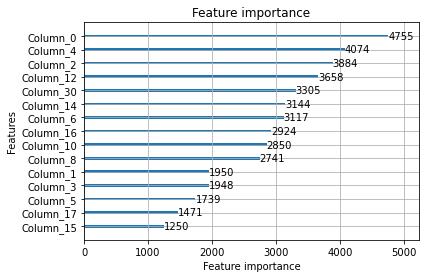

In [37]:
lgb.plot_importance(model_lgb, max_num_features=15)

In [38]:
np.array(fea_lambdarank)[[0,4,2,12,30,6,14,10,16,8,1,3,5,17,15]]

array(['product_sku_hash_id_sim', 'product_sku_hash_id_lag4_sim',
       'product_sku_hash_id_lag2_sim', 'product_sku_hash_id_imgsim',
       'neg_sku_score', 'product_sku_hash_id_descsim',
       'product_sku_hash_id_lag2_imgsim',
       'product_sku_hash_id_lag4_descsim',
       'product_sku_hash_id_lag4_imgsim',
       'product_sku_hash_id_lag2_descsim', 'product_sku_hash_id_lag1_sim',
       'product_sku_hash_id_lag3_sim', 'product_sku_hash_id_lag5_sim',
       'product_sku_hash_id_lag5_imgsim',
       'product_sku_hash_id_lag3_imgsim'], dtype='<U34')

In [39]:
# this takes too many memory
del df_train
gc.collect()

40

In [40]:
del lgb_train, lgb_val, dtrain_x, dval_x, dtrain_y, dval_y, dtrain_group, dval_group
gc.collect()

20

# Testing set's MRR

In [158]:
df_test = pd.read_parquet('df_test_update8')

In [159]:
df_test['n'] = df_test.groupby('session_id_hash').cumcount()
df_test['query_id'] = df_test['session_id_hash'] + '_' + df_test['n'].astype(str)

In [1]:
# get topK predicted sku list in test set
batch_size = 2000
tf_test = tf.data.Dataset.from_tensor_slices({'sku':df_test[fea_prod].values, 'url':df_test[fea_url].values}).batch(batch_size)
dist_test = strategy.experimental_distribute_dataset(tf_test)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
topk=tf.constant(20)

for x in dist_test:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 100 == 0:
        print(i, time.time()-s)
        
neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_test['neg_sku_list'] = neg_sku_list
df_test['neg_sku_score'] = score_list
del neg_sku_list, score_list
gc.collect()

In [ ]:
# explode df_test with topK sku
df_test = df_test.apply(explode).reset_index(drop=True)
df_test = df_test.rename(columns = {'neg_sku_list': 'target_sku'})

In [ ]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_update8.npy')
    add_fea_using_matrix(df_test, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

In [42]:
# predict for df_test
y_pred_test = model_lgb.predict(df_test[fea_lambdarank].values)
df_test['label_pred'] = y_pred_test
del y_pred_test
gc.collect()

44

In [43]:
# sort df_test by query_id, and label_pred descending
df_test.sort_values(['query_id','label_pred'], ascending=False, inplace=True)

In [44]:
# implode df_test: groupby (query_id, next_sku) agg list
df_test_r = pd.DataFrame(df_test.groupby(['query_id', 'session_id_hash','next_interacted_sku', 'next_sku', 'rand_id']).agg({'label_pred':list, 'target_sku': list})).reset_index()


In [45]:
# r = df_test.apply(lambda x: x['sku_list'][0:20].index(x['next_sku']))
def get_r(x):
    try:
        return x['target_sku'][0:20].index(x['next_interacted_sku']) + 1
    except ValueError:
        return 1000000

df_test_r['r'] = df_test_r[['target_sku','next_interacted_sku']].parallel_apply(get_r, axis=1)
df_test_r['rr'] = 1/df_test_r['r']

In [47]:
topk=tf.constant(20)

rr = df_test_r.rr.values
print('MRR=%.4f'%np.mean(rr))
out_rr = (rr<1/20)
print('%d out of %d records (%.2f%%) with prediction outside top%d'%(
    out_rr.sum(), out_rr.shape[0], (out_rr.mean())*100., topk.numpy()), flush=True)

print('---------------------------')
print('random pick one per session')
# rr = df_test.groupby(['session_id_hash'])['rr'].sample(1)
cond = df_test_r.groupby(['session_id_hash'])['rand_id'].transform(min) == df_test_r['rand_id']
print('MRR=%.4f ' % np.mean(rr[cond]))
print('%d out of %d sessions (%.2f%%) with prediction outside top%d'%(
    out_rr[cond].sum(), out_rr[cond].shape[0], (out_rr[cond].mean())*100., topk.numpy()), flush=True)

MRR=0.3216
136411 out of 312691 records (43.62%) with prediction outside top20
---------------------------
random pick one per session
MRR=0.3640 
18545 out of 52660 sessions (35.22%) with prediction outside top20


In [188]:
del df_test, df_test_r
# del model_lgb
gc.collect()

40

## prepare submission

In [49]:
df_submission = pd.read_parquet('df_submission')

In [50]:
df_submission.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,train,server_day,product_sku_hash_id,hashed_url_id,...,product_action_id_lag1,product_action_id_lag2,product_action_id_lag3,product_action_id_lag4,product_action_id_lag5,sess_step,next_sku,next_interacted_sku,kfoldidx,rand_id
0,000028429ab6afd40f2a4d59c183ea46390fdfa3d04c80...,event_product,detail,4641de8468a39c53a151e8ee5f3bd731e69b3d7ac61335...,2019-05-09 20:07:15.044,4f7f239c607d10b0843ceeccb98aecb382f8c18a931758...,0,2019-05-09,11210,74134,...,0,0,0,0,0,0,25402,25402.0,-1,0
1,000074f533a4fb893af451e4d436d326ddd2a7e83151a9...,event_product,detail,7571fbadb886e669ea4ac666b585fcc798c1f5970867c5...,2019-04-16 19:37:19.867,0301401ac53e67e319036bbb0c12a4715ec5df45614023...,0,2019-04-16,18597,2718,...,0,0,0,0,0,0,25402,25402.0,-1,0
2,0000a6d196680bebf931ad7670f479c5c5357b3f1f8943...,pageview,_,_,2019-05-01 16:53:08.695,9cfe9b259c3c4029a5d20e3542905d07ccf50d9a3bd4d7...,0,2019-05-01,25402,146255,...,0,0,0,0,0,0,25402,25402.0,-1,0
3,0001f7b93896b89ad8272f56cc2fe3ae39e9624d31ab4f...,event_product,detail,e3c30b1ca9efaf74fb64a74f2416121d3efe169936d8a7...,2019-05-10 00:38:49.491,2b3dfa89ecba708d637bf997472319f548ef3e0913505f...,0,2019-05-10,36029,40280,...,0,2,0,2,2,6,25402,25402.0,-1,3
4,00024ffd94a577c77010e94625814bc15cf49fc367169f...,pageview,_,_,2019-04-28 22:05:18.401,9c2fdd5f2c20115d95abcf93bb984408f4ced15a9aa334...,0,2019-04-28,25402,145439,...,0,0,0,0,0,0,25402,25402.0,-1,0


In [52]:
# get topK predicted sku list in test set
batch_size = 2000
tf_submission = tf.data.Dataset.from_tensor_slices({'sku':df_submission[fea_prod].values, 'url':df_submission[fea_url].values}).batch(batch_size)
dist_submission = strategy.experimental_distribute_dataset(tf_submission)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
topk=tf.constant(20)

for x in dist_submission:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 100 == 0:
        print(i, time.time()-s)
        
neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_submission['neg_sku_list'] = neg_sku_list
df_submission['neg_sku_score'] = score_list
del neg_sku_list, score_list
gc.collect()

0

In [55]:
df_submission = df_submission.apply(explode).reset_index(drop=True)
df_submission = df_submission.rename(columns = {'neg_sku_list': 'target_sku'})

In [56]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_update8.npy')
    add_fea_using_matrix(df_submission, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

created product_sku_hash_id_sim
created product_sku_hash_id_lag1_sim
created product_sku_hash_id_lag2_sim
created product_sku_hash_id_lag3_sim
created product_sku_hash_id_lag4_sim
created product_sku_hash_id_lag5_sim
created product_sku_hash_id_descsim
created product_sku_hash_id_lag1_descsim
created product_sku_hash_id_lag2_descsim
created product_sku_hash_id_lag3_descsim
created product_sku_hash_id_lag4_descsim
created product_sku_hash_id_lag5_descsim
created product_sku_hash_id_imgsim
created product_sku_hash_id_lag1_imgsim
created product_sku_hash_id_lag2_imgsim
created product_sku_hash_id_lag3_imgsim
created product_sku_hash_id_lag4_imgsim
created product_sku_hash_id_lag5_imgsim
created product_sku_hash_id_catesame
created product_sku_hash_id_lag1_catesame
created product_sku_hash_id_lag2_catesame
created product_sku_hash_id_lag3_catesame
created product_sku_hash_id_lag4_catesame
created product_sku_hash_id_lag5_catesame
created product_sku_hash_id_pricesame
created product_sku_ha

In [57]:
# predict for df_submission
y_pred_sub = model_lgb.predict(df_submission[fea_lambdarank].values)
df_submission['label_pred'] = y_pred_sub
del y_pred_sub
gc.collect()

# sort df_test by query_id, and label_pred descending
df_submission.sort_values(['session_id_hash','label_pred'], ascending=False, inplace=True)
df_submission = pd.DataFrame(df_submission.groupby(['session_id_hash',]).agg({'label_pred':list, 'target_sku': list})).reset_index()


In [70]:
test_file='./data/rec_test_phase_1.json'
with open(test_file) as json_file:
    # read the test cases from the provided file
    test_queries = json.load(json_file)

In [95]:
def set_submission(q):
    sess_id = q['query'][0]['session_id_hash']
    try:
        next_sku_id = df_submission.loc[df_submission.session_id_hash == sess_id, 'target_sku'].values[0][0:20]
        next_sku = skucate.categories[next_sku_id].tolist()
    except (ValueError, IndexError):
        # query with only search events not exists in df_test
        next_sku = np.random.choice(skucate.categories, 20, False).tolist()
    
    # copy the test case
    _pred = dict(q)

    # append the label - which needs to be a list
    _pred["label"] = next_sku
    return _pred


In [96]:
my_predictions = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(set_submission)(q) for q in tqdm(test_queries))
# check for consistency
assert len(my_predictions) == len(test_queries)

  0%|          | 0/142327 [00:00<?, ?it/s]

In [97]:
EMAIL = ''
local_prediction_file = '{}_{}.json'.format(EMAIL.replace('@', '_'), round(time.time() * 1000))
# dump to file
with open(local_prediction_file, 'w') as outfile:
    json.dump(my_predictions, outfile, indent=2)

In [98]:
print(local_prediction_file)

louiskitlung_connect.hku.hk_1622013600547.json


In [100]:
from dotenv import load_dotenv
from datetime import datetime
import boto3
load_dotenv(verbose=True, dotenv_path='./submission/upload.env')

BUCKET_NAME = os.getenv('BUCKET_NAME') # you received it in your e-mail
EMAIL = os.getenv('EMAIL') # the e-mail you used to sign up
PARTICIPANT_ID = os.getenv('PARTICIPANT_ID') # you received it in your e-mail
AWS_ACCESS_KEY = os.getenv('AWS_ACCESS_KEY') # you received it in your e-mail
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY') # you received it in your e-mail

def upload_submission(
        local_file: str,
        task: str
):
    """
    Thanks to Alex Egg for catching the bug!

    :param local_file: local path, may be only the file name or a full path
    :param task: rec or cart
    :return:
    """

    print("Starting submission at {}...\n".format(datetime.utcnow()))
    # instantiate boto3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY ,
        aws_secret_access_key=AWS_SECRET_KEY,
        region_name='us-west-2'
    )
    s3_file_name = os.path.basename(local_file)
    # prepare s3 path according to the spec
    s3_file_path = '{}/{}/{}'.format(task, PARTICIPANT_ID, s3_file_name)  # it needs to be like e.g. "rec/id/*.json"
    # upload file
    s3_client.upload_file(local_file, BUCKET_NAME, s3_file_path)
    # say bye
    print("\nAll done at {}: see you, space cowboy!".format(datetime.utcnow()))

    return


In [101]:
upload_submission(local_file=local_prediction_file, task='rec')

Starting submission at 2021-05-26 07:22:47.142922...


All done at 2021-05-26 07:22:52.780986: see you, space cowboy!


In [35]:
!date

Mon May 17 04:36:37 UTC 2021
